In [45]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [46]:
# Importing the dataset
csdv_df = pd.read_csv('customer_segmentation.csv')

In [47]:
csdv_df.head() #first 5 entries of the dataset to understand the data we are dealing with

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [48]:
print("Dataset info:")
csdv_df.info()
print()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13801 non-null  object 
 1   customer_id                    13801 non-null  object 
 2   order_status                   13801 non-null  object 
 3   order_purchase_timestamp       13801 non-null  object 
 4   order_approved_at              13801 non-null  object 
 5   order_delivered_carrier_date   13801 non-null  object 
 6   order_delivered_customer_date  13801 non-null  object 
 7   order_estimated_delivery_date  13801 non-null  object 
 8   payment_type                   13801 non-null  object 
 9   payment_installments           13801 non-null  int64  
 10  payment_value                  13801 non-null  float64
 11  customer_unique_id             13801 non-null  object 
 12  customer_city                  1

In [49]:
print("Dataset shape:")
 #number of rows and columns of our dataset
print(csdv_df.shape)

Dataset shape:
(13801, 26)


In [50]:
csdv_df.describe() #compute some useful descriptive statistics which summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000


Io toglierei product_category_name, product_name_length e product_description_length (non so se altro)

In [51]:
csdv_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

In [52]:
csdv_df_new = csdv_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state', 'product_category_name_english']]

csdv_df_new

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,belo horizonte,SP,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,SP,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.90,18.92,belo horizonte,SP,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,MG,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.70,9.34,belo horizonte,SP,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,SC,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.90,22.75,belo horizonte,SP,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,SC,2,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.90,22.75,belo horizonte,SP,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13796,493ba21a937e956c5e0e4e26c9f1b7f9,408d74d06be5d5140bb933f248de1342,delivered,2018-07-15 09:56:32,2018-07-16 13:30:36,2018-07-27 07:26:00,2018-08-02 18:06:41,2018-07-26 00:00:00,boleto,1,...,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-07-20 13:30:36,19.99,7.40,sao paulo,SP,books_imported
13797,4a7cf245701068d38d441791b735e4bd,1d3b24ba06f2e3fa4bfa74fd70d2310f,delivered,2018-05-07 20:36:47,2018-05-07 20:51:50,2018-05-08 15:04:00,2018-05-09 22:38:53,2018-05-17 00:00:00,credit_card,1,...,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-05-11 20:51:50,18.99,7.39,sao paulo,SP,books_imported
13798,33f8dfc5a51063c31d7b12e9d43a45fc,8f7f4871646eb2fa410cc2d50b861317,delivered,2018-04-28 14:32:54,2018-04-28 14:53:18,2018-05-02 15:25:00,2018-05-03 23:51:56,2018-05-14 00:00:00,credit_card,1,...,SP,1,82d7b276f49e72ffce78d10b20518808,7c5b05cbdb5542049f38d90d7815b97d,2018-05-04 14:53:18,18.99,7.39,sao paulo,SP,books_imported
13799,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,invoiced,2018-07-11 22:27:32,2018-07-11 22:45:43,2018-07-11 22:45:43,2018-07-20 00:00:00,2018-07-20 00:00:00,credit_card,1,...,SP,1,5b668636d65ddf4e4109c6d8fb13ea56,7c5b05cbdb5542049f38d90d7815b97d,2018-07-16 22:45:43,44.99,7.58,sao paulo,SP,books_imported


In [53]:
csdv_df_new['customer_unique_id'].nunique()


11247

In [54]:
csdv_df_new['customer_id'].nunique()

11394

customer_id e customer_unique_id are basically the same so it is indifferent which one to use.

In [55]:
# null values
csdv_df_new.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name_english    0
dtype: int64

There are no null values

In [56]:
csdv_df_new.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name_english    0
dtype: int64

In [57]:
csdv_df_new.duplicated().sum()
csdv_df_new.drop_duplicates(keep='first', inplace=True)
csdv_df_new.reset_index(drop=True, inplace=True)

C:\Users\giulia macis\AppData\Local\Temp\ipykernel_1204\3515545850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csdv_df_new.drop_duplicates(keep='first', inplace=True)


In [58]:
csdv_df_new[['shipping_limit_date']]

,shipping_limit_date
0,2018-07-30 03:24:27
1,2018-08-13 14:31:29
2,2018-07-13 03:45:45
3,2018-08-23 10:50:54
4,2018-08-23 10:50:54
...,...
13713,2018-07-20 13:30:36
13714,2018-05-11 20:51:50
13715,2018-05-04 14:53:18
13716,2018-07-16 22:45:43


This attribute is not described, but we deduced that it corresponds to the date and time deadline at which the ship can be sent.

In [59]:
csdv_df_new[['order_delivered_carrier_date']]

,order_delivered_carrier_date
0,2018-07-26 14:31:00
1,2018-08-10 14:34:00
2,2018-07-11 15:01:00
3,2018-08-22 15:21:00
4,2018-08-22 15:21:00
...,...
13713,2018-07-27 07:26:00
13714,2018-05-08 15:04:00
13715,2018-05-02 15:25:00
13716,2018-07-11 22:45:43


C:\Users\giulia macis\AppData\Local\Temp\ipykernel_1204\789764561.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = csdv_df_new.corr() #compute pairwise correlation of columns excluding NA/null values


<AxesSubplot: >

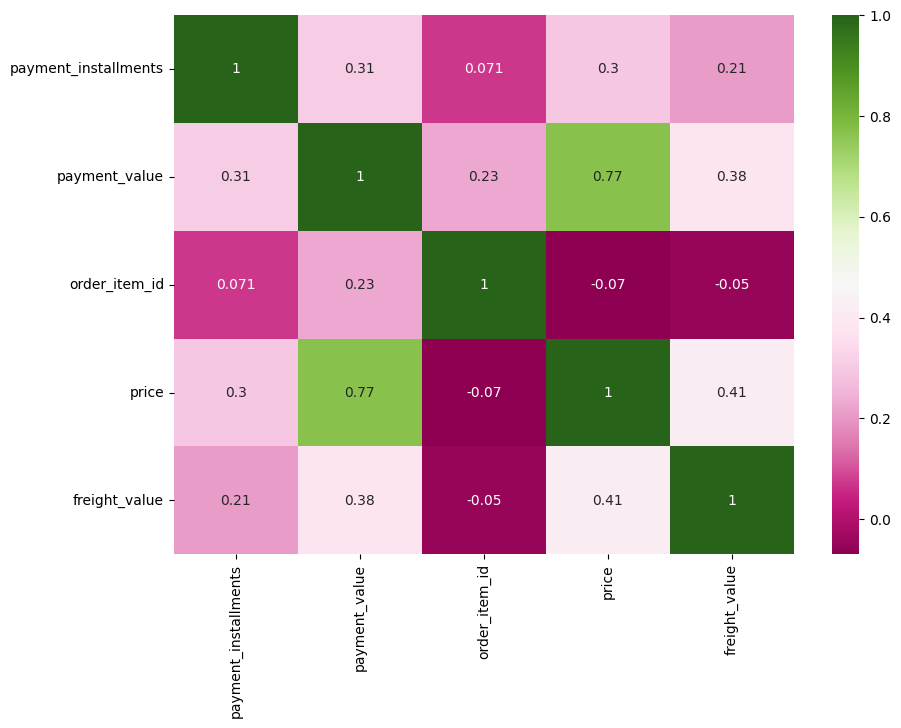

In [60]:
correlation = csdv_df_new.corr() #compute pairwise correlation of columns excluding NA/null values
table = plt.figure(figsize=(10,7))
sns.heatmap(correlation, annot=True, cmap="PiYG")

This evaluates the correlation only among numerical variables

In [61]:
customer_state_counts = csdv_df_new.groupby('customer_state').size()
customer_state_counts

customer_state
AC       5
AL      56
AM      24
AP      12
BA     532
CE     206
DF     297
ES     284
GO     272
MA      86
MG    1461
MS     111
MT     154
PA     150
PB      92
PE     270
PI      80
PR     618
RJ    1744
RN      81
RO      26
RR       9
RS     630
SC     432
SE      55
SP    5986
TO      45
dtype: int64

These are the abbreviations of the federative states of Brazil

In [62]:
customer_state_counts_df = pd.DataFrame([customer_state_counts]).T.reset_index()
customer_state_counts_df.columns = ['customer_state', 'Count']
customer_state_counts_df

,customer_state,Count
0,AC,5
1,AL,56
2,AM,24
3,AP,12
4,BA,532
5,CE,206
6,DF,297
7,ES,284
8,GO,272
9,MA,86


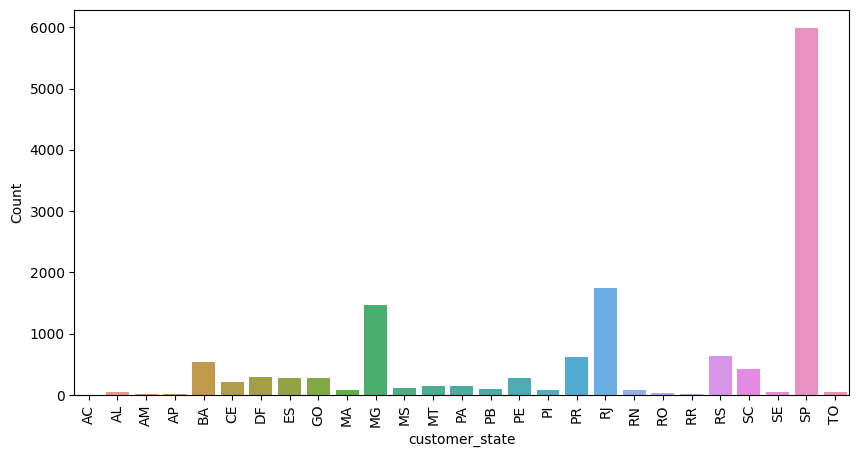

In [63]:
plt.figure(figsize=(10,5))
sns.barplot(x='customer_state', y='Count', data=customer_state_counts_df)
plt.xticks(rotation=90)
plt.show()

We can notice that the majority of the customers purchase from São Paulo state.

In [64]:
state_payment_df = csdv_df_new.groupby(['customer_state', 'payment_type']).count().reset_index()

state_payment_df = state_payment_df.drop(columns=['customer_id', 'order_status', 'order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date', 'payment_installments', 'payment_value','customer_unique_id', 'customer_city', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'seller_city', 'seller_state', 'product_category_name_english'])

state_payment_df.columns = ['customer_state', 'payment_type', 'count']
state_payment_df

,customer_state,payment_type,count
0,AC,boleto,1
1,AC,credit_card,4
2,AL,boleto,8
3,AL,credit_card,45
4,AL,debit_card,2
...,...,...,...
92,SP,voucher,202
93,TO,boleto,13
94,TO,credit_card,28
95,TO,debit_card,2


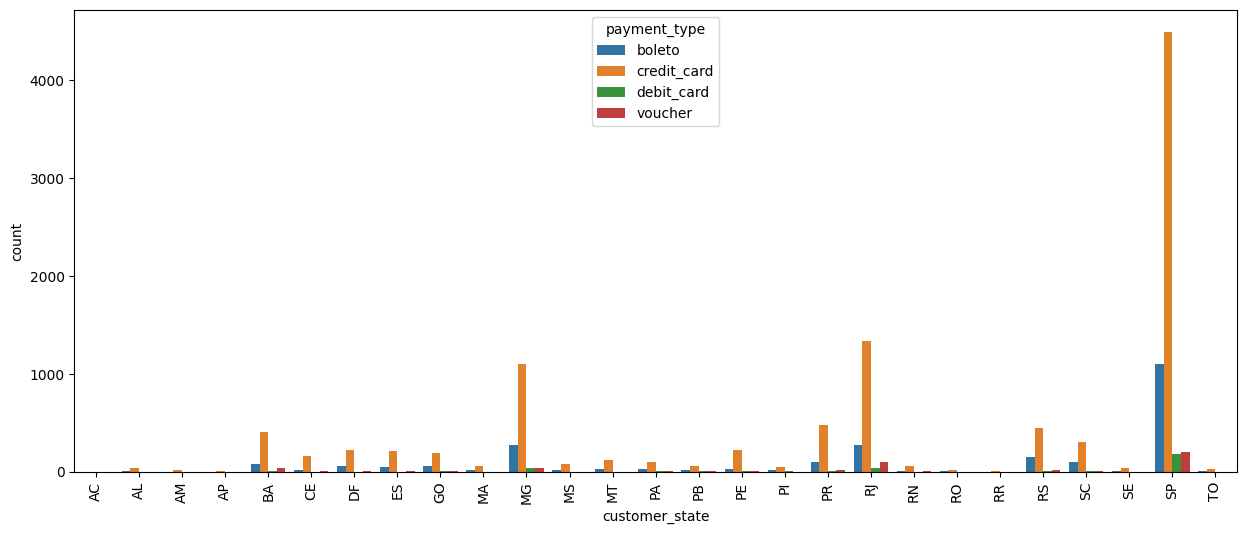

In [65]:
plt.figure(figsize=(15,6))
sns.barplot(x='customer_state', y='count', hue='payment_type', data=state_payment_df)
plt.xticks(rotation=90)
plt.show()

### OUTLIERS

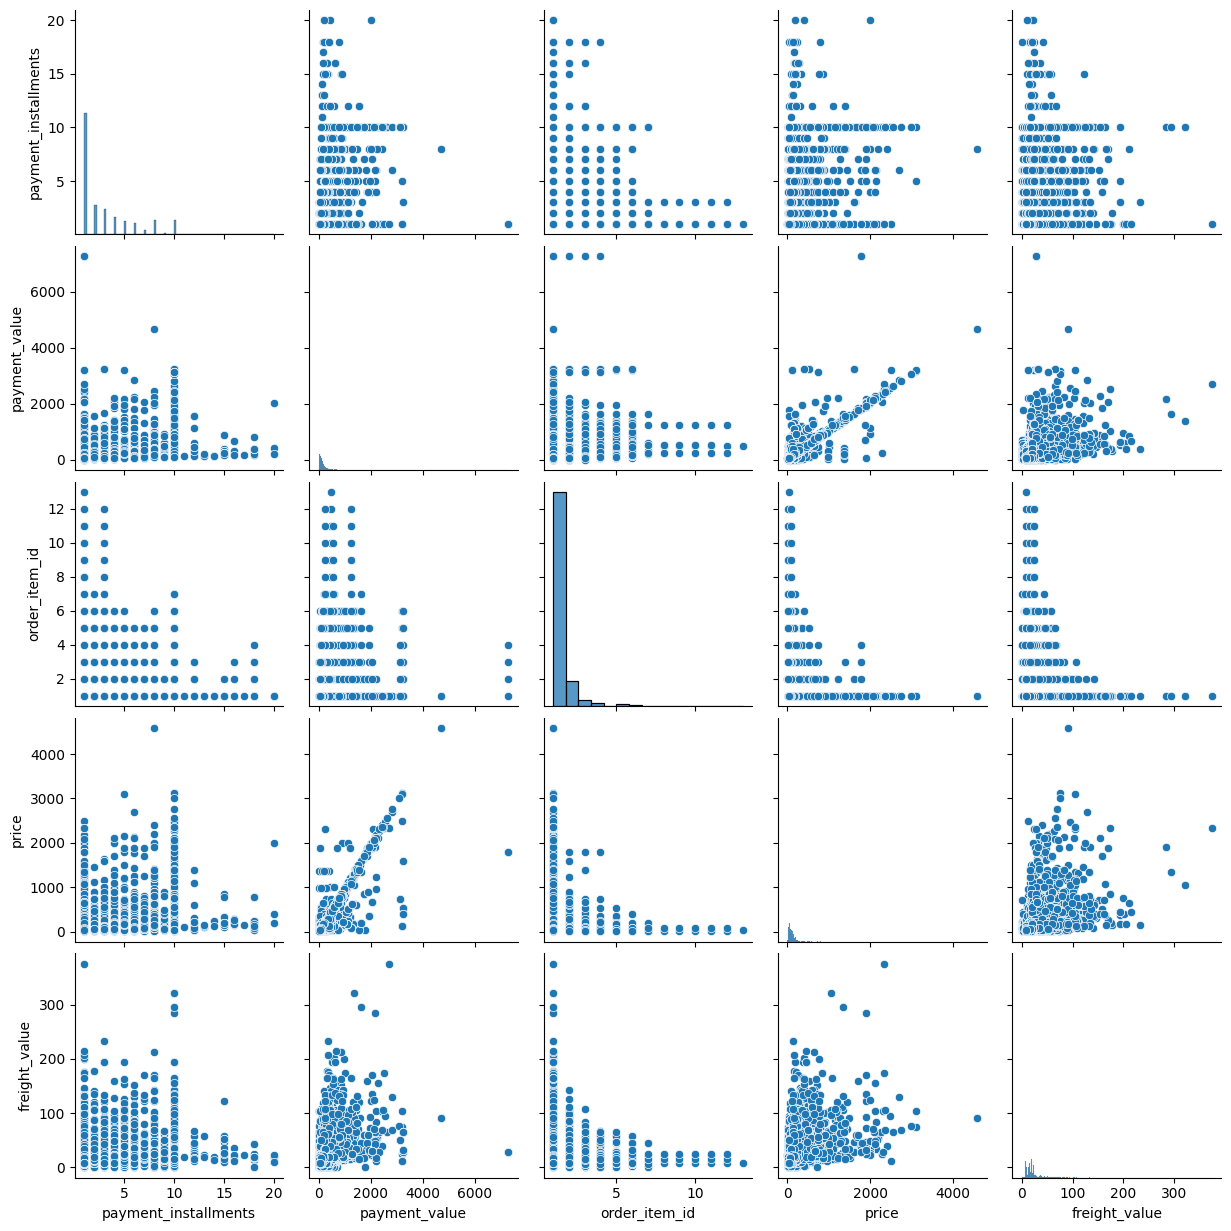

In [66]:
sns.pairplot(csdv_df_new)

In [67]:
'''outlier = csdv_df_new[csdv_df_new.payment_value > 4000]
csdv_df_new = csdv_df_new.drop(outlier.index)
csdv_df_new = csdv_df_new.reset_index(drop=True)
csdv_df_new'''

'outlier = csdv_df_new[csdv_df_new.payment_value > 4000]\ncsdv_df_new = csdv_df_new.drop(outlier.index)\ncsdv_df_new = csdv_df_new.reset_index(drop=True)\ncsdv_df_new'

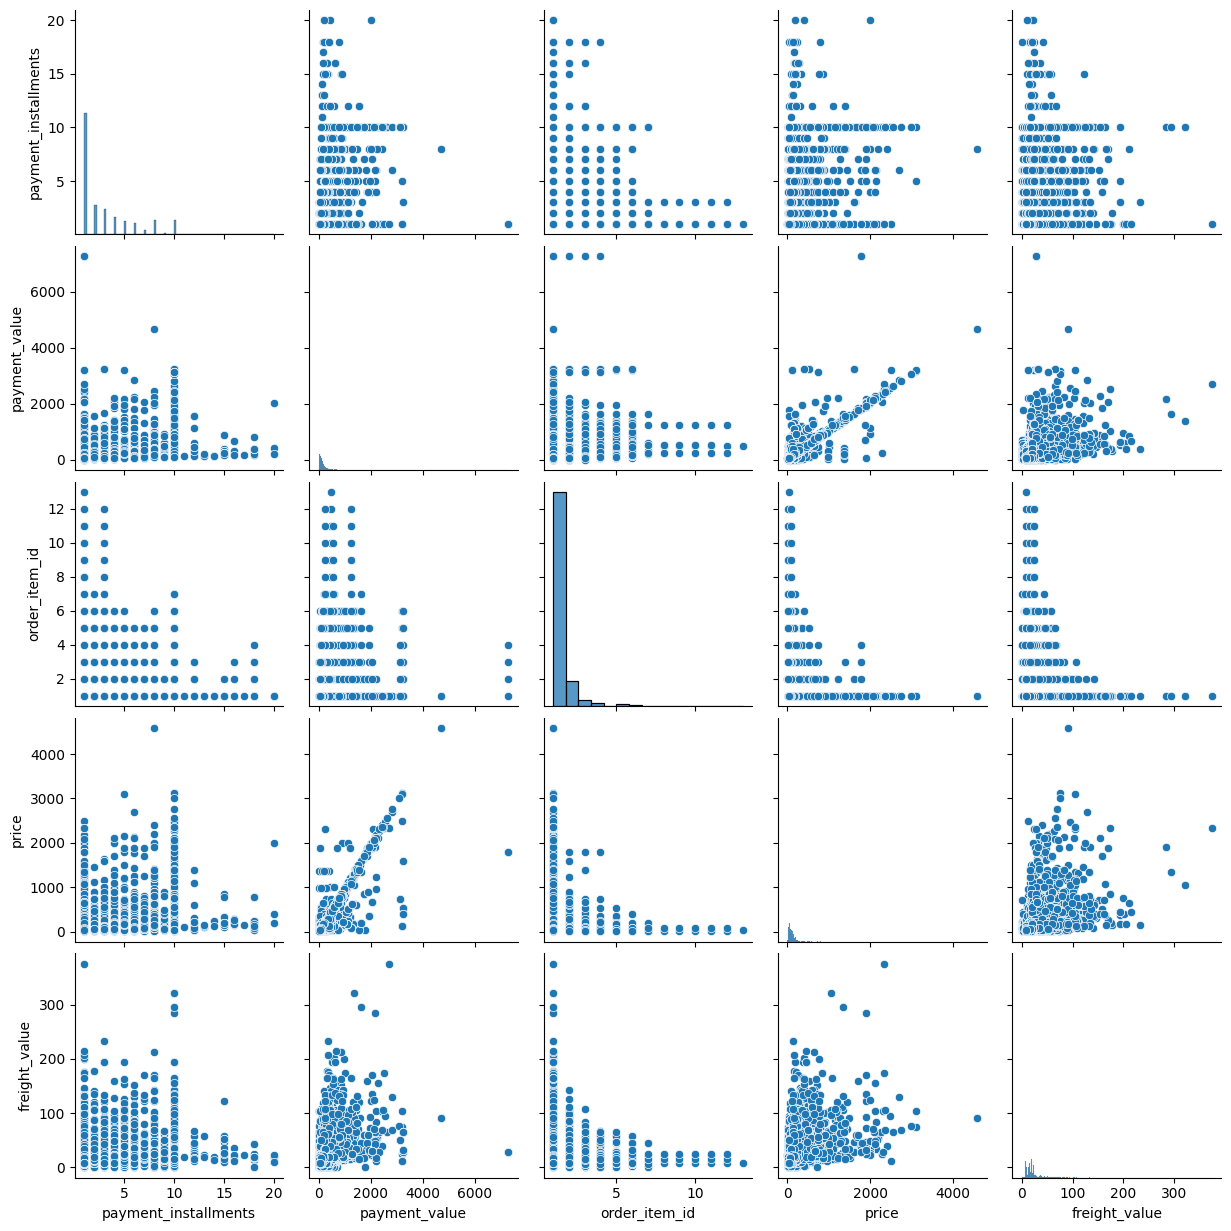

In [68]:
sns.pairplot(csdv_df_new)

In [69]:
#calculating the number of customers each month
customers=csdv_df_new[['order_purchase_timestamp', 'customer_unique_id']]
customers['month'] = pd.DatetimeIndex(customers['order_purchase_timestamp']).month
customers = customers.groupby(['month']).count().reset_index()
customers = customers.drop(columns=['order_purchase_timestamp'])
customers.columns = ['month','count' ]
customers

C:\Users\giulia macis\AppData\Local\Temp\ipykernel_1204\4211560061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['month'] = pd.DatetimeIndex(customers['order_purchase_timestamp']).month


,month,count
0,1,6
1,2,22
2,3,125
3,4,2054
4,5,3188
5,6,2858
6,7,2758
7,8,2696
8,9,1
9,10,3


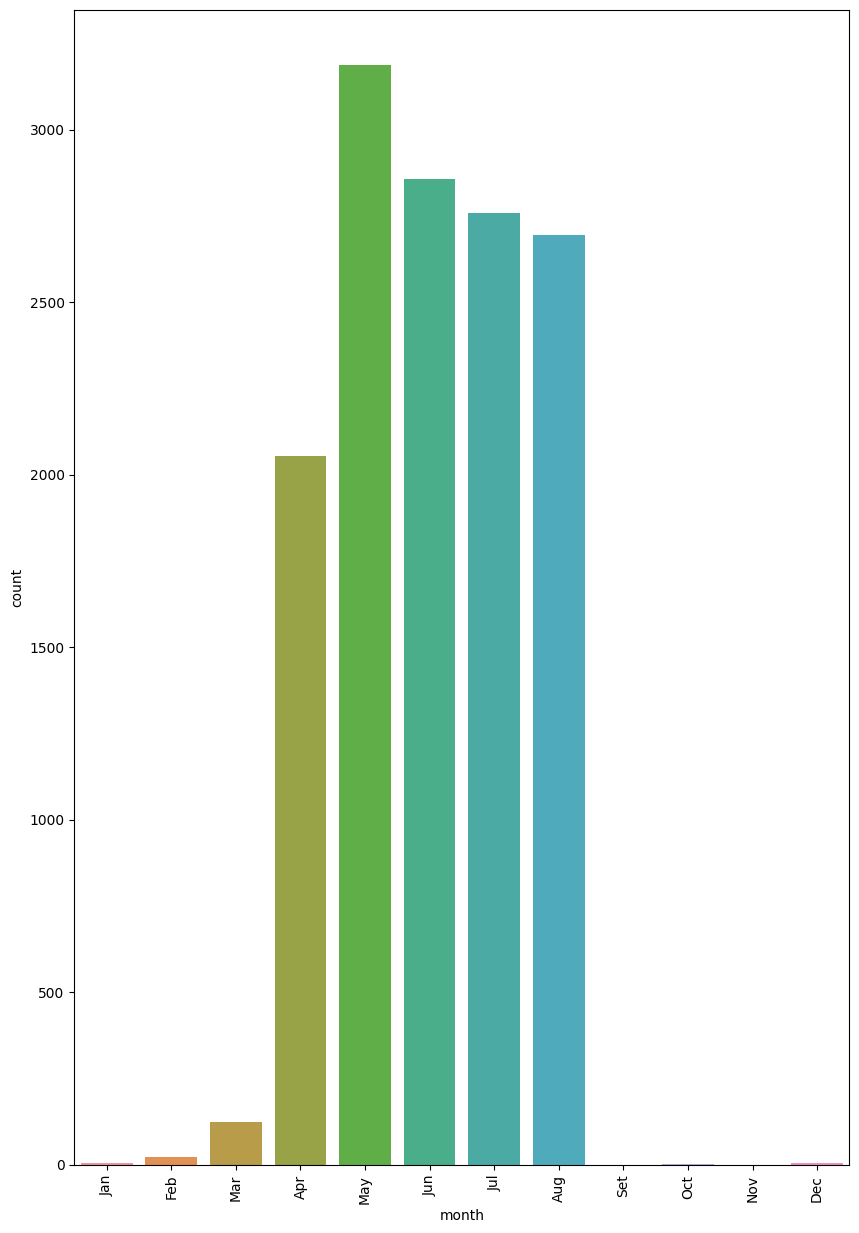

In [70]:
plt.figure(figsize=(10,15))
bar = sns.barplot(x='month', y='count',  data=customers)
plt.xticks(rotation=90)
ax1 = plt.subplot()
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Set', 'Oct', 'Nov', 'Dec'])
plt.show()

#### ONE HOT ENCODING

In [71]:
csdv_df_new = pd.get_dummies(csdv_df_new,
                             prefix=['customer_state:', 'payment_type:', 'seller_state:', 'product_category_name:'],
                             columns=['customer_state', 'payment_type', 'seller_state',
                                      'product_category_name_english'], drop_first=False)

csdv_df_new
#CHIEDI AL PROF PERCHE CON ONE HOT ENCODING PERDIAMO DELLE RIGHE (CONFRONTA CON QUELLO DOPO OUTLIERS)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_installments,payment_value,...,product_category_name:_pet_shop,product_category_name:_signaling_and_security,product_category_name:_small_appliances,product_category_name:_small_appliances_home_oven_and_coffee,product_category_name:_sports_leisure,product_category_name:_stationery,product_category_name:_tablets_printing_image,product_category_name:_telephony,product_category_name:_toys,product_category_name:_watches_gifts
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,...,0,0,0,0,0,0,0,0,0,0
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,5,135.82,...,0,0,0,0,0,0,0,0,0,0
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,1,128.04,...,0,0,0,0,0,0,0,0,0,0
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,...,0,0,0,0,0,0,0,0,0,0
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13713,493ba21a937e956c5e0e4e26c9f1b7f9,408d74d06be5d5140bb933f248de1342,delivered,2018-07-15 09:56:32,2018-07-16 13:30:36,2018-07-27 07:26:00,2018-08-02 18:06:41,2018-07-26 00:00:00,1,27.39,...,0,0,0,0,0,0,0,0,0,0
13714,4a7cf245701068d38d441791b735e4bd,1d3b24ba06f2e3fa4bfa74fd70d2310f,delivered,2018-05-07 20:36:47,2018-05-07 20:51:50,2018-05-08 15:04:00,2018-05-09 22:38:53,2018-05-17 00:00:00,1,26.38,...,0,0,0,0,0,0,0,0,0,0
13715,33f8dfc5a51063c31d7b12e9d43a45fc,8f7f4871646eb2fa410cc2d50b861317,delivered,2018-04-28 14:32:54,2018-04-28 14:53:18,2018-05-02 15:25:00,2018-05-03 23:51:56,2018-05-14 00:00:00,1,26.38,...,0,0,0,0,0,0,0,0,0,0
13716,442a41b00a8a8bda35511fdf1eb65cc5,e42e2e8642f9c09100b6667e321c2811,invoiced,2018-07-11 22:27:32,2018-07-11 22:45:43,2018-07-11 22:45:43,2018-07-20 00:00:00,2018-07-20 00:00:00,1,52.57,...,0,0,0,0,0,0,0,0,0,0


#### CALCULATING RFM

##### Recency value

 lo abbiamo fatto in tre modi, chiedere al prof se sono giusti e quale usare

In [72]:
#modo 1
customer_group = csdv_df_new[['customer_unique_id', 'order_purchase_timestamp']]
customer_group=customer_group.groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')
customer_group=customer_group.to_frame() #perche prima era una series
customer_unique_id=csdv_df_new[['customer_unique_id']]
customer_group_new= pd.concat([customer_group, customer_unique_id], axis=1)
customer_group_new.drop_duplicates(keep='first', inplace=True)
customer_group_new.reset_index(drop=True, inplace=True)
customer_group_new=customer_group_new.sort_values(by='customer_unique_id')
customer_group_new


,order_purchase_timestamp,customer_unique_id
7092,2018-05-10 10:56:27,0000366f3b9a7992bf8c76cfdf3221e2
10246,2018-08-21 11:34:26,000ec5bff359e1c0ad76a81a45cb598f
4707,2018-07-28 00:23:49,00172711b30d52eea8b313a7f2cced02
5376,2018-08-24 21:17:00,001928b561575b2821c92254a2327d06
5916,2018-05-01 09:25:32,0019e8c501c85848ac0966d45226fa1d
...,...,...
11054,2018-04-25 12:08:11,ffecceca389973ef16660d58696f281e
3773,2018-07-27 22:40:35,ffee94d548cef05b146d825a7648dab4
5313,2018-04-20 11:03:47,fff2ae16b99c6f3c785f0e052f2a9cfb
8580,2018-07-20 13:47:30,fff3e1d7bc75f11dc7670619b2e61840


In [73]:
#modo 2

customer_group_3 = csdv_df_new[['customer_unique_id', 'order_purchase_timestamp']]
customer_group_3=customer_group_3.groupby(['customer_unique_id']).max().reset_index()
customer_group_3.columns= ['customer_unique_id','last_purchase_timestamp']
customer_group_3.drop_duplicates(keep='first', inplace=True)
customer_group_3.reset_index(drop=True, inplace=True)
customer_group_3

,customer_unique_id,last_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21 11:34:26
2,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49
3,001928b561575b2821c92254a2327d06,2018-08-24 21:17:00
4,0019e8c501c85848ac0966d45226fa1d,2018-05-01 09:25:32
...,...,...
11242,ffecceca389973ef16660d58696f281e,2018-04-25 12:08:11
11243,ffee94d548cef05b146d825a7648dab4,2018-07-27 22:40:35
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,2018-04-20 11:03:47
11245,fff3e1d7bc75f11dc7670619b2e61840,2018-07-20 13:47:30


In [74]:
customer_group_new['order_purchase_timestamp'] = pd.to_datetime(customer_group_new['order_purchase_timestamp'])
customer_group_new['order_purchase_timestamp'] = customer_group_new['order_purchase_timestamp'].dt.date
customer_group_new

,order_purchase_timestamp,customer_unique_id
7092,2018-05-10,0000366f3b9a7992bf8c76cfdf3221e2
10246,2018-08-21,000ec5bff359e1c0ad76a81a45cb598f
4707,2018-07-28,00172711b30d52eea8b313a7f2cced02
5376,2018-08-24,001928b561575b2821c92254a2327d06
5916,2018-05-01,0019e8c501c85848ac0966d45226fa1d
...,...,...
11054,2018-04-25,ffecceca389973ef16660d58696f281e
3773,2018-07-27,ffee94d548cef05b146d825a7648dab4
5313,2018-04-20,fff2ae16b99c6f3c785f0e052f2a9cfb
8580,2018-07-20,fff3e1d7bc75f11dc7670619b2e61840


In [75]:
#modo 3


csdv_df_new['order_purchase_timestamp'] = pd.to_datetime(csdv_df_new['order_purchase_timestamp'])

df_recency = csdv_df_new.groupby(by='customer_unique_id',
                        as_index=False)['order_purchase_timestamp'].max()

df_recency.columns = ['customer_unique_id', 'LastPurchaseDate']
df_recency['LastPurchaseDate'] =df_recency['LastPurchaseDate'].dt.date
recent_date = df_recency['LastPurchaseDate'].max() #perche prende solo una data??
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111
1,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21,8
2,00172711b30d52eea8b313a7f2cced02,2018-07-28,32
3,001928b561575b2821c92254a2327d06,2018-08-24,5
4,0019e8c501c85848ac0966d45226fa1d,2018-05-01,120
...,...,...,...
11242,ffecceca389973ef16660d58696f281e,2018-04-25,126
11243,ffee94d548cef05b146d825a7648dab4,2018-07-27,33
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,2018-04-20,131
11245,fff3e1d7bc75f11dc7670619b2e61840,2018-07-20,40


##### Frequency value


In [76]:
frequency_dataframe=csdv_df_new[['customer_id', 'customer_unique_id']]
frequency_dataframe = frequency_dataframe.groupby(['customer_unique_id'], as_index=False).count()
frequency_dataframe.columns = ['Customer unique id','count' ]
frequency_dataframe

,Customer unique id,count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,000ec5bff359e1c0ad76a81a45cb598f,1
2,00172711b30d52eea8b313a7f2cced02,1
3,001928b561575b2821c92254a2327d06,2
4,0019e8c501c85848ac0966d45226fa1d,1
...,...,...
11242,ffecceca389973ef16660d58696f281e,1
11243,ffee94d548cef05b146d825a7648dab4,1
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,1
11245,fff3e1d7bc75f11dc7670619b2e61840,1


### monetary value

In [77]:
monetary_value= csdv_df_new[[ 'customer_unique_id', 'payment_value']]
monetary_value=monetary_value.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_value.columns = ['Customer Id', 'Monetary Value']
monetary_value

,Customer Id,Monetary Value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,000ec5bff359e1c0ad76a81a45cb598f,27.75
2,00172711b30d52eea8b313a7f2cced02,122.07
3,001928b561575b2821c92254a2327d06,329.62
4,0019e8c501c85848ac0966d45226fa1d,197.27
...,...,...
11242,ffecceca389973ef16660d58696f281e,72.76
11243,ffee94d548cef05b146d825a7648dab4,35.36
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,200.90
11245,fff3e1d7bc75f11dc7670619b2e61840,82.51


In [78]:
score_dataframe = df_recency[['customer_unique_id']]
score_dataframe['Recency'] = df_recency[['Recency']]
score_dataframe['Monetary Value']= monetary_value[['Monetary Value']]
score_dataframe['Frequency']=frequency_dataframe['count']
score_dataframe

C:\Users\giulia macis\AppData\Local\Temp\ipykernel_1204\1716631289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_dataframe['Recency'] = df_recency[['Recency']]


,customer_unique_id,Recency,Monetary Value,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,111,141.90,1
1,000ec5bff359e1c0ad76a81a45cb598f,8,27.75,1
2,00172711b30d52eea8b313a7f2cced02,32,122.07,1
3,001928b561575b2821c92254a2327d06,5,329.62,2
4,0019e8c501c85848ac0966d45226fa1d,120,197.27,1
...,...,...,...,...
11242,ffecceca389973ef16660d58696f281e,126,72.76,1
11243,ffee94d548cef05b146d825a7648dab4,33,35.36,1
11244,fff2ae16b99c6f3c785f0e052f2a9cfb,131,200.90,1
11245,fff3e1d7bc75f11dc7670619b2e61840,40,82.51,1


### CLUSTERING ALGORITHMS

Io come algoritmi vorrei usare:
- KMeans
- Hierarcical Clustering (Agglomerative)
- Spectral Clustering o Gaussian Model

#### KMEANS

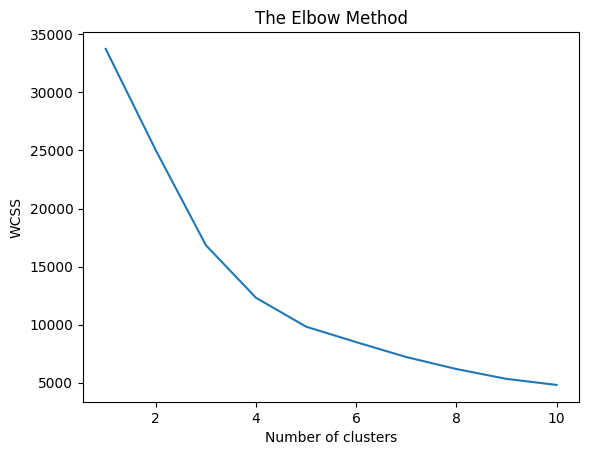

In [79]:
# K-Means Clustering
from sklearn.preprocessing import StandardScaler

X = score_dataframe[['Recency', 'Monetary Value', 'Frequency']]

sc_X = StandardScaler()
X_scd = sc_X.fit_transform(X)


# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []


for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scd)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()



In [80]:
#transforming X into a matrix
#X1=X_scd.to_numpy()

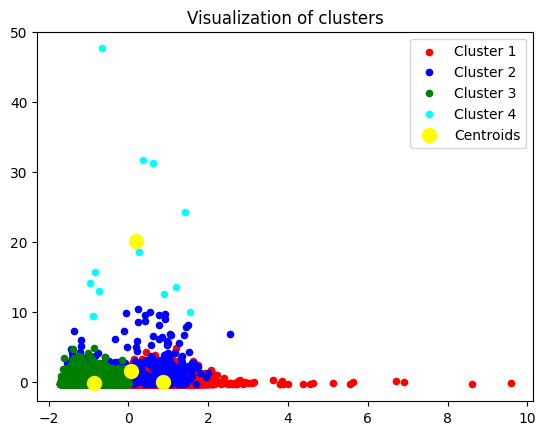

In [81]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scd)
y_kmeans
# Visualising the clusters
plt.scatter(X_scd[y_kmeans == 0, 0], X_scd[y_kmeans == 0, 1], s = 20, c = 'yellow', label = 'Cluster 1')
plt.scatter(X_scd[y_kmeans == 1, 0], X_scd[y_kmeans == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scd[y_kmeans == 2, 0], X_scd[y_kmeans == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X_scd[y_kmeans == 3, 0], X_scd[y_kmeans == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 30, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'red', label = 'Centroids')
plt.title('Visualization of clusters')

plt.legend()
plt.show()

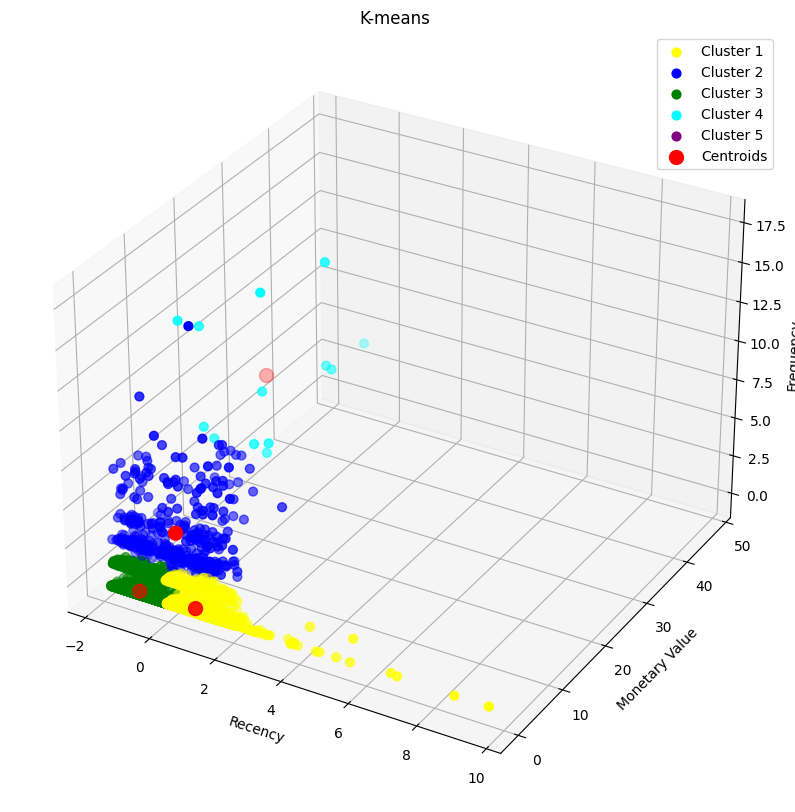

In [103]:
fig= plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scd[y_kmeans == 0,0],X_scd[y_kmeans == 0,1],X_scd[y_kmeans == 0,2], s = 40 , color = 'yellow', label = "Cluster 1")
ax.scatter(X_scd[y_kmeans == 1,0],X_scd[y_kmeans == 1,1],X_scd[y_kmeans == 1,2], s = 40 , color = 'blue', label = "Cluster 2")
ax.scatter(X_scd[y_kmeans == 2,0],X_scd[y_kmeans == 2,1],X_scd[y_kmeans == 2,2], s = 40 , color = 'green', label = "Cluster 3")
ax.scatter(X_scd[y_kmeans == 3,0],X_scd[y_kmeans == 3,1],X_scd[y_kmeans == 3,2], s = 40 , color = 'cyan', label = "Cluster 4")
#ax.scatter(X_scd[y_kmeans == 4,0],X_scd[y_kmeans == 4,1],X_scd[y_kmeans == 4,2], s = 40 , color = 'purple', label = "Cluster 5")
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s = 100, c = 'red', label = 'Centroids')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary Value')
ax.set_zlabel('Frequency')
ax.legend()
plt.title('K-means')
plt.show()

In [82]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


score_kmeans_s = silhouette_score(X_scd, kmeans.labels_, metric='euclidean')
score_kmeans_c = calinski_harabasz_score(X_scd, kmeans.labels_)
score_kmeans_d = davies_bouldin_score(X_scd, y_kmeans)

print('Silhouette Score: %.3f' % score_kmeans_s)
print('Calinski Harabasz Score: %.3f' % score_kmeans_c)
print('Davies Bouldin Score: %.3f' % score_kmeans_d)

Silhouette Score: 0.492
Calinski Harabasz Score: 6521.886
Davies Bouldin Score: 0.722


#### HIERARCHICAL CLUSTERING

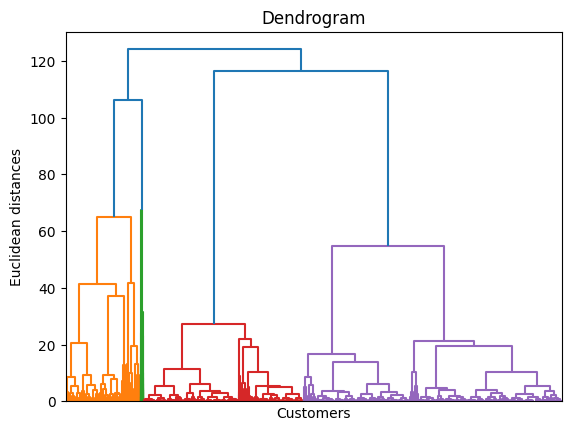

In [83]:
# Hierarchical Clustering

# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_scd, method = 'ward'))
# Ward's method: distance between two clusters A and B is how much the sum of squares will increase when we merge them
# single for min distance
# complete for max distance
# average for centroid distance
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.xticks([])    #no ticks are displayed
plt.show()



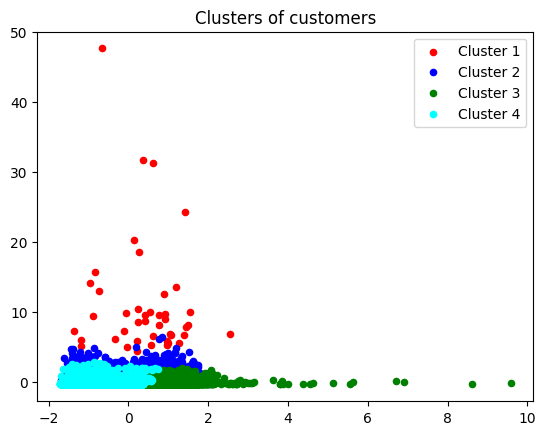

In [84]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_scd)

# Visualising the clusters
plt.scatter(X_scd[y_hc == 0, 0], X_scd[y_hc == 0, 1], s = 20, c = 'red', label = 'Cluster 1')
plt.scatter(X_scd[y_hc == 1, 0], X_scd[y_hc == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scd[y_hc == 2, 0], X_scd[y_hc == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X_scd[y_hc == 3, 0], X_scd[y_hc == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X1[y_hc == 4, 0], X1[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
#plt.scatter(X[y_hc == 5, 0], X[y_hc == 5, 1], s = 100, c = 'black', label = 'Cluster 6')
#plt.scatter(X[y_hc == 6, 0], X[y_hc == 6, 1], s = 100, c = 'orange', label = 'Cluster 7')
plt.title('Clusters of customers')
#plt.xlabel('Annual Income (k$)')
#plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [85]:
score_hc_s = silhouette_score(X_scd, hc.labels_, metric='euclidean')
score_hc_c = calinski_harabasz_score(X_scd, hc.labels_)
score_hc_d = davies_bouldin_score(X_scd, y_hc)

print('Silhouette Score: %.3f' % score_hc_s)
print('Calinski Harabasz Score: %.3f' % score_hc_c)
print('Davies Bouldin Score: %.3f' % score_hc_d)

Silhouette Score: 0.485
Calinski Harabasz Score: 5533.921
Davies Bouldin Score: 0.871


#### Gaussian mixture model

[[-0.02062473 -0.21479482 -0.32871889]
 [ 0.07636854  0.54298795 -0.32871889]
 [ 0.06567274  2.22456081  3.87227525]
 [ 0.04280465  0.1773971   1.16747754]]


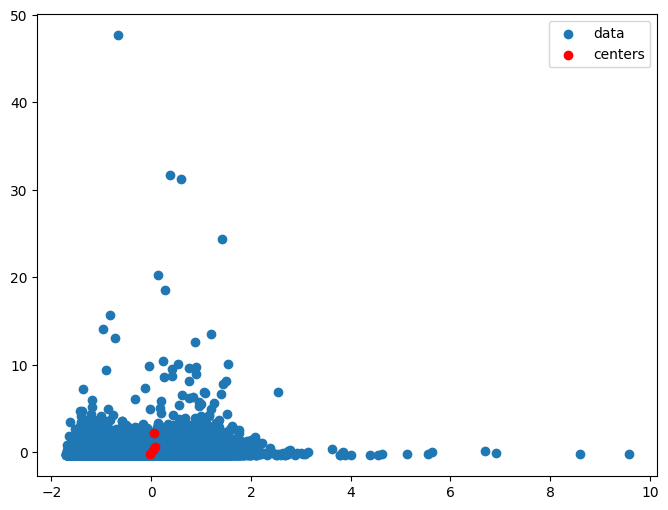

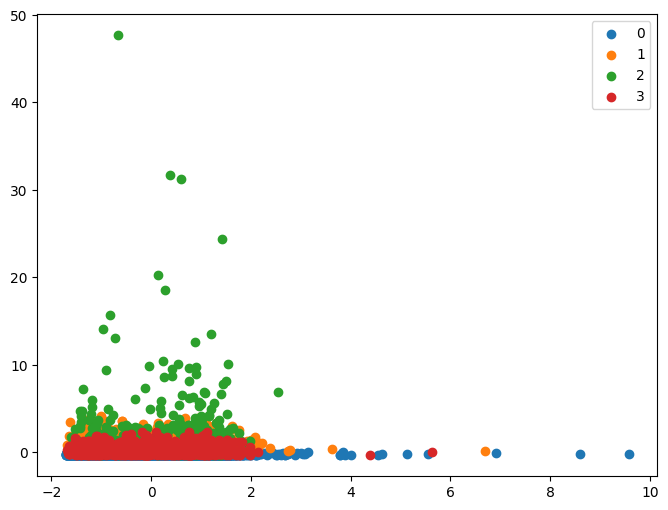

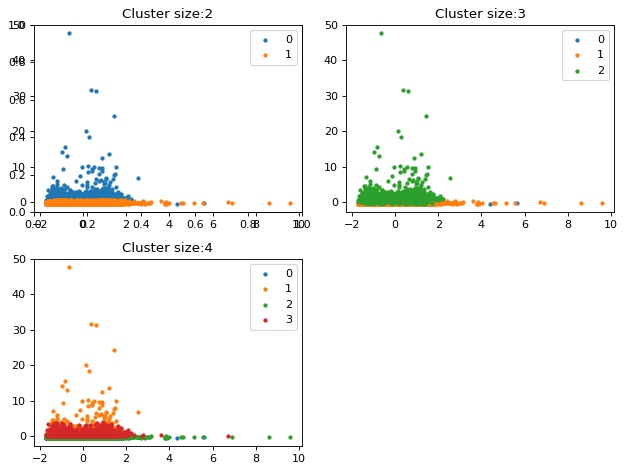

In [86]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from numpy import random
from pandas import DataFrame

#random.seed(234)
#x, _ = make_blobs(n_samples=330, centers=5, cluster_std=1.84)
#plt.figure(figsize=(8, 6))
#plt.scatter(x[:,0], x[:,1])
#plt.show()

gm = GaussianMixture(n_components=4).fit(X_scd)
centers = gm.means_
print(centers)

plt.figure(figsize=(8, 6))
plt.scatter(X_scd[:,0], X_scd[:,1], label="data")
plt.scatter(centers[:,0], centers[:,1],c='r', label="centers")
plt.legend()
plt.show()


pred = gm.predict(X_scd)

df = DataFrame({'x':X_scd[:,0], 'y':X_scd[:,1], 'label':pred})
groups = df.groupby('label')

ig, ax = plt.subplots(figsize=(8, 6))
for name, group in groups:
    ax.scatter(group.x, group.y, label=name)

ax.legend()
plt.show()


f = plt.figure(figsize=(8, 6), dpi=80)
f.add_subplot(2, 2, 1)

for i in range(2, 5):
 gm = GaussianMixture(n_components=i).fit(X_scd)
 pred = gm.predict(X_scd)
 df = DataFrame({'x':X_scd[:,0], 'y':X_scd[:,1], 'label':pred})
 groups = df.groupby('label')
 f.add_subplot(2, 2, i-1)
 for name, group in groups:
    plt.scatter(group.x, group.y, label=name, s=8)
    plt.title("Cluster size:" + str(i))
    plt.legend()


plt.tight_layout()
plt.show()

###### metodo 3

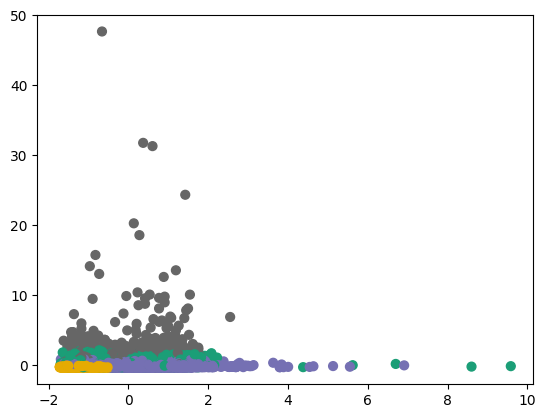

In [87]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X_scd)
labels = gmm.predict(X_scd)
plt.scatter(X_scd[:, 0], X_scd[:, 1], c=labels, s=40, cmap= 'Dark2')
plt.show()

##### modo 4

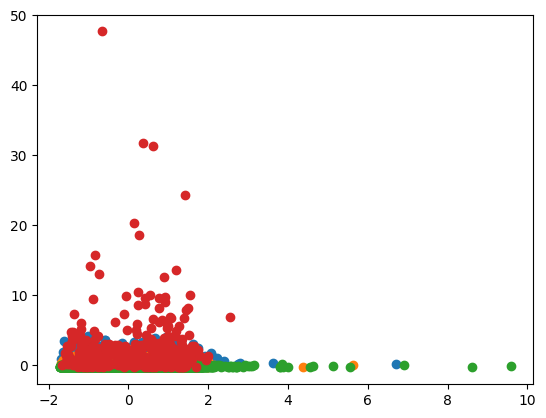

In [88]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
model = GaussianMixture(n_components=4)
# fit the model
model.fit(X_scd)
# assign a cluster to each example
yhat = model.predict(X_scd)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X_scd[row_ix, 0], X_scd[row_ix, 1])
# show the plot
pyplot.show()

In [91]:
score_m_s = silhouette_score(X_scd, model.labels_, metric='euclidean')
score_m_c = calinski_harabasz_score(X_scd, model.labels_)
score_m_d = davies_bouldin_score(X_scd, y_hc)
print('Silhouette Score: %.3f' % score_m_s)
print('Calinski Harabasz Score: %.3f' % score_m_c)
print('Davies Bouldin Score: %.3f' % score_m_d)

AttributeError: 'GaussianMixture' object has no attribute 'labels_'

#### prova con Spectral

C:\Users\giulia macis\Documents\GitHub\270341\venv\lib\site-packages\sklearn\cluster\_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  est = KMeans(


SpectralClustering(n_clusters=4)


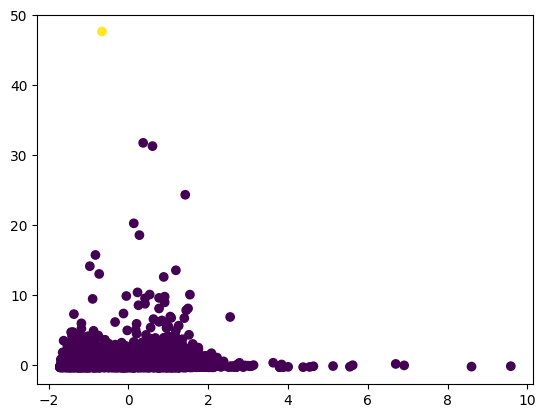

C:\Users\giulia macis\Documents\GitHub\270341\venv\lib\site-packages\sklearn\cluster\_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  est = KMeans(
C:\Users\giulia macis\Documents\GitHub\270341\venv\lib\site-packages\sklearn\cluster\_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  est = KMeans(
C:\Users\giulia macis\Documents\GitHub\270341\venv\lib\site-packages\sklearn\cluster\_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  est = KMeans(


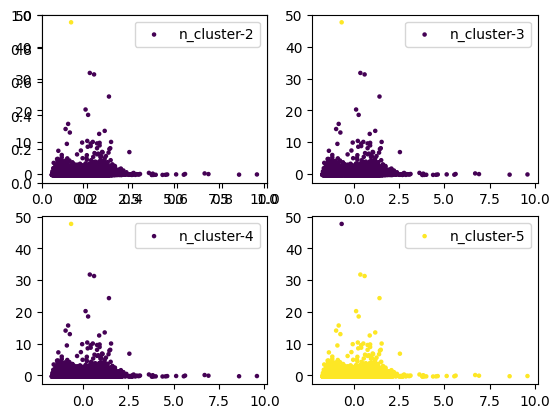

In [92]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=4).fit(X_scd)
print(sc)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)
labels = sc.labels_

plt.scatter(X_scd[:,0], X_scd[:,1], c=labels)
plt.show()
f = plt.figure()
f.add_subplot(2, 2, 1)
for i in range(2, 6):
 sc = SpectralClustering(n_clusters=i).fit(X_scd)
 f.add_subplot(2, 2, i-1)
 plt.scatter(X_scd[:,0], X_scd[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()

plt.show()

#### birch clustering
BIRCH Clustering (BIRCH is short for Balanced Iterative Reducing and Clustering using
Hierarchies) involves constructing a tree structure from which cluster centroids are extracted.
BIRCH incrementally and dynamically clusters incoming multi-dimensional metric data points to try to produce the best quality clustering with the available resources (i. e., available memory and time constraints).

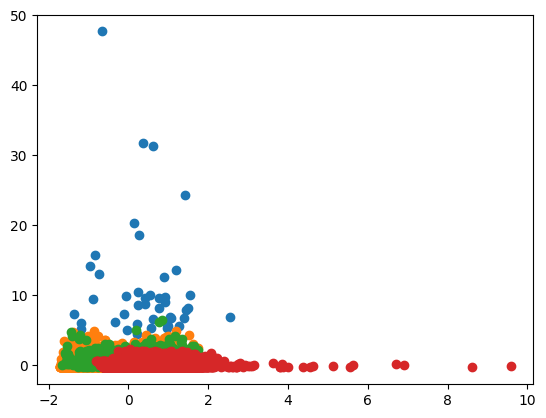

In [93]:
# birch clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# define the model
model = Birch(threshold=0.01, n_clusters=4)
# fit the model
model.fit(X_scd)
# assign a cluster to each example
yhat = model.predict(X_scd)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
 # get row indexes for samples with this cluster
 row_ix = where(yhat == cluster)
 # create scatter of these samples
 pyplot.scatter(X_scd[row_ix, 0], X_scd[row_ix, 1])
# show the plot
pyplot.show()

In [94]:
score_birch_s = silhouette_score(X_scd, model.labels_, metric='euclidean')
score_birch_c = calinski_harabasz_score(X_scd, model.labels_)
score_birch_d = davies_bouldin_score(X_scd, yhat)

print('Silhouette Score: %.3f' % score_birch_s)
print('Calinski Harabasz Score: %.3f' % score_birch_c)
print('Davies Bouldin Score: %.3f' % score_birch_d)

Silhouette Score: 0.442
Calinski Harabasz Score: 5095.204
Davies Bouldin Score: 0.881
